The function IV() is written according to the LUA script (VoltageOnCurrent.dat).  
The function IV_new() is modified based on IV() by considering the Knudsen Diffusion: 
    if Fkn = False, it is the exactly same as IV()
    if Fkn = True, it considers the Knudsen Diffusion's influence

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [2]:
# original I-V relationship from voltageoncurrent.dat
def IV(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys):
    #-- B Koeppel
    #-- 10-13-2014
    #--
    #-------------------------------------------------------------------
    #--                                                               --
    #--       VoltageValue()                                          --
    #--                                                               --
    #--       V-I performance based on spreadsheet EC model           --
    #--       Updated to include SOA performance                      --
    #--                                                               --
    #-------------------------------------------------------------------
    #--
    #-- Available Local Inputs From SOFC-MP
#    oT =700.0                       #Temperature oxidant (K)
#    fT =700.0                        #Temperature fuel (K)
#    J=0.01                         # Current density (A/cm2)
#    pO2air=0.3                    # Air side partial pressure O2 (atm)
#    pN2air =0.7                    #Air side partial pressure N2 (atm)
#    pH2 = 0.1                       #Fuel side partial pressure H2 (atm)
#    pH2O =0.9                      #Fuel side partial pressure H2O (atm)
#    pCO=0.0                       # Fuel side partial pressure CO (atm)
#    pCO2=0.0                      # Fuel side partial pressure CO2 (atm)
#    pCH4=0.0                      # Fuel side partial pressure CH4 (atm)
#    pN2=0.0                       # Fuel side partial pressure N2 (atm)
#    pSys=1.0                      #System pressure (atm)
    #--nActiveCell               # Cell number
    #--   DistanceFromTheEdge        Distance along path (m)
    #--   DistanceFromTheEdgeRatio   Relative distance along the path 
    #--
    #-- Required Subroutine Outputs
    #--   Z                          Voltage (V)
    #--
    #------------------------------------------------------------------
    #--
    #-- User-Assigned Geometry/Material Inputs
    #--   th_a       Thickness anode (microns)
    #--   th_e       Thickness electrolyte (microns)
    #--   th_c       Thickness cathode (microns)
    #--   th_ic      Thickness interconnect (microns)
    #--   por_a      Porosity anode (%)
    #--   por_c      Porosity cathode (%)
    #--   tort_a     Tortuosity anode
    #--   tort_c     Tortuosity cathode
    #--   BV_alpha   Butler-Volmer 'alpha' constant
    #--   BV_prexp   Butler-Volmer pre-exponential constant
    #--   BV_Eact    Butler-Volmer activation energy
    #--   R_cont     Contact resistance
    #--
    #-- User-Assigned Constants/Conversions
    #--   R          Ideal gas constant
    #--   F          Faraday's constant
    #--   atm2Pa     Conversion for pressure atm -> Pa
    #--   mic2m      Conversion for length micron -> m
    #------------------------------------------------------------------
    #--
    #function VoltageValue()
    #--
    #--J=-J
    #-- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    atm2Pa=101325.0
    mic2m=1.0e-6
    #--
    #-- Assign Flags
    BVflag=0        #-- 0=old method, 1=pressurized method
    #--
    #-- Assign Geometry/Material Data
    th_a=           300.0
    th_e=           10.0
    th_c=           30.0
    th_ic=          500.0
    por_a=          40.0
    por_c=          40.0
    tort_a=         2.5
    tort_c=         2.5
    BV_alpha=       0.43236
    BV_prexp=       5639.0
    BV_Eact=        79616.0
    R_cont=         0.0
    BV_alpha2a=     0.44
    BV_prexp2a=     1.43E+04
    BV_Eact2a=      8.00E+04
    BV_gamma2a=     0.5
    BV_alpha2f=     9.01
    BV_prexp2f=     1.31E+07
    BV_Eact2f=      8.00E+04
    BV_gamma2f=     0.133
    V_loss=         0.0
    #--
    #%-- Compute the local cell temperature
    #------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    #--
    #%-- Compute the Nernst open circuit voltage
    #------------------------------------------------------------------
    Keq_dHo=-56930.0
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--
    #%-- Compute the ohmic polarization
    #------------------------------------------------------------------
    #-- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    #%-- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    #%-- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117
    s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    #%-- Compute the anode conductivity
    s_aA=1000
    s_a=s_aA*(1.0-(0.018*por_a))
    #%-- Compute the effective cell resistivity
    Ri=R_cont+(th_e/s_e+th_a/s_a+th_ic/s_ic+th_c/s_c)*0.0001
    #%-- Compute the total ohmic loss
    Ohmic=Ri*J
    #--
    #%-- Compute the activation polarization (old method or new pressurized method)
    #------------------------------------------------------------------
    if BVflag==0:
    #  -- Old method
      i0=BV_prexp*math.exp(-BV_Eact/R/Tk)
      BV=(R*Tk/BV_alpha/F)*math.log((J/2.0/i0)+math.sqrt((J/2.0/i0)**2+1))
    else:
    #  -- New method
      ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
      ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
      eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
      eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
      BV=eta_f+eta_a
    
    #--
    #%-- Compute the diffusion coefficients
    #------------------------------------------------------------------
    #-- Make 0.0 species non-zero to make equations defined
    if pCO<=0 :
      pCOc=1e-16
    else:
      pCOc=pCO
    
    if pCO2<=0 :
      pCO2c=1e-16
    else:
      pCO2c=pCO2
    
    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    #-- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0
    H2Oii=18.0
    COii=28.0
    CO2ii=44.0
    N2ii=28.0
    O2ii=32.0
    CH4ii=16.0
    #%-- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    #%-- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    #%-- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
    DsurfH2th1=0.1
    DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    #--
    #%-- Compute the cathode concentration polarization
    #------------------------------------------------------------------
    Deffc=0.01*por_c*O2N2/tort_c
    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(pSys/(pSys-pO2air))
    #--ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    #--
    #%-- Compute the anode concentration polarization
    #------------------------------------------------------------------
    DeffH2=D_H2
    DeffH2O=0.01*H2O_UD*por_a/tort_a
    DeffCO=0.01*CO_UD*por_a/tort_a
    DeffCO2=0.01*CO2_UD*por_a/tort_a
    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    #-- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim) :
      Jcalc=J
    else:
      Jcalc=J
    
    OPa_A=(Jcalc+blim+dlim)/blim/dlim
    OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
    OPa_C=(Jcalc-alim-clim)/alim/clim
    holdA1=OPa_A
    holdB1=OPa_B
    holdC1=OPa_C
    stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
    stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A
#     print('stabcheck: ', stabcheck)
#     print('stabcheck2: ', stabcheck2)
    if stabcheck>0 :
      if stabcheck2>0 :
        Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
        holdA2=0
        holdB2=0
        holdC2=0
        goober=1
      else:
        DeffH2=0.01*H2_UD*por_a/tort_a
        DeffH2O=0.01*H2O_UD*por_a/tort_a
        DeffCO=0.01*CO_UD*por_a/tort_a
        DeffCO2=0.01*CO2_UD*por_a/tort_a
        alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
        blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
        clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
        dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
        OPa_A=(Jcalc+blim+dlim)/blim/dlim
        OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
        OPa_C=(Jcalc-alim-clim)/alim/clim
        holdA2=OPa_A
        holdB2=OPa_B
        holdC2=OPa_C
        Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
        goober=2
    
    #--
    #%-- Compute the final voltage result
    #------------------------------------------------------------------
   # print(Voc,Ohmic,BV,Cath)
    V=(Voc-Ohmic-BV+Cath+Anod)+V_loss #this is the original one for SOFC
    #--file=io.open("vdetails.dat","a")
    #V=(Voc+Ohmic+BV-Cath-Anod)+V_loss #SOEC proton
    #Z=V #*1.1+0.05
  #  print(V,"(V)=",Voc,"(Voc)+",Ohmic,"(Ohmic)+",BV,"(BV)-",Cath,"(Cath)-",Anod,"Anod)")
   
    #--Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--file:write(Voc," ",Ohmic," ",BV," ",Cath," ",Anod," ",pN2air," ",pH2," ",pH2O," ",pCO," ",pCO2," ",pCH4,"\n")
    #--pO2anode=(pH2O/Kequib/pH2)**2
    #--file:write(Voc,"=",pO2air,"/",pO2anode,"  =",pH2O,"/",Kequib,"/",pH2,"\n")
    #--file:close()
    #--
    #-- return the voltage value
    return(V,Voc,Ohmic,BV,Cath,Anod)

# updated I-V relationship by considering Knudsen Dissuion
def IV_new(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,BV_alpha,BV_prexp,BV_Eact,Fkn=False, de_a=100**(-6),ne_a=0.5,alpha_a=1,de_c=100**(-6),ne_c=0.5,alpha_c=1):
    #-- B Koeppel
    #-- 10-13-2014
    #--
    #-------------------------------------------------------------------
    #--                                                               --
    #--       VoltageValue()                                          --
    #--                                                               --
    #--       V-I performance based on spreadsheet EC model           --
    #--       Updated to include SOA performance                      --
    #--                                                               --
    #-------------------------------------------------------------------
    #--
    #-- Available Local Inputs From SOFC-MP
#    oT =700.0                       #Temperature oxidant (K)
#    fT =700.0                        #Temperature fuel (K)
#    J=0.01                         # Current density (A/cm2)
#    pO2air=0.3                    # Air side partial pressure O2 (atm)
#    pN2air =0.7                    #Air side partial pressure N2 (atm)
#    pH2 = 0.1                       #Fuel side partial pressure H2 (atm)
#    pH2O =0.9                      #Fuel side partial pressure H2O (atm)
#    pCO=0.0                       # Fuel side partial pressure CO (atm)
#    pCO2=0.0                      # Fuel side partial pressure CO2 (atm)
#    pCH4=0.0                      # Fuel side partial pressure CH4 (atm)
#    pN2=0.0                       # Fuel side partial pressure N2 (atm)
#    pSys=1.0                      #System pressure (atm)
    #--nActiveCell               # Cell number
    #--   DistanceFromTheEdge        Distance along path (m)
    #--   DistanceFromTheEdgeRatio   Relative distance along the path 
    #--
    #-- Required Subroutine Outputs
    #--   Z                          Voltage (V)
    #--
    #------------------------------------------------------------------
    #--
    #-- User-Assigned Geometry/Material Inputs
    #--   th_a       Thickness anode (microns)
    #--   th_e       Thickness electrolyte (microns)
    #--   th_c       Thickness cathode (microns)
    #--   th_ic      Thickness interconnect (microns)
    #--   por_a      Porosity anode (%)
    #--   por_c      Porosity cathode (%)
    #--   tort_a     Tortuosity anode
    #--   tort_c     Tortuosity cathode
    #--   BV_alpha   Butler-Volmer 'alpha' constant
    #--   BV_prexp   Butler-Volmer pre-exponential constant
    #--   BV_Eact    Butler-Volmer activation energy
    #--   R_cont     Contact resistance
    #--
    #-- User-Assigned Constants/Conversions
    #--   R          Ideal gas constant
    #--   F          Faraday's constant
    #--   atm2Pa     Conversion for pressure atm -> Pa
    #--   mic2m      Conversion for length micron -> m
    #------------------------------------------------------------------
    #--
    #function VoltageValue()
    #--
    #--J=-J
    #-- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    atm2Pa=101325.0
    mic2m=1.0e-6
    #--
    #-- Assign Flags
    BVflag=0        #-- 0=old method, 1=pressurized method
    #--
    #-- Assign Geometry/Material Data
    th_a=           300.0
    th_e=           10.0
    th_c=           30.0
    th_ic=          500.0
    por_a=          40.0
    por_c=          40.0
    tort_a=         2.5
    tort_c=         2.5
#     BV_alpha=       0.43236
#     BV_prexp=       5639.0
#     BV_Eact=        79616.0
    R_cont=         0.0
    BV_alpha2a=     0.44
    BV_prexp2a=     1.43E+04
    BV_Eact2a=      8.00E+04
    BV_gamma2a=     0.5
    BV_alpha2f=     9.01
    BV_prexp2f=     1.31E+07
    BV_Eact2f=      8.00E+04
    BV_gamma2f=     0.133
    V_loss=         0.0
    #--
    #%-- Compute the local cell temperature
    #------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    #--
    #%-- Compute the Nernst open circuit voltage
    #------------------------------------------------------------------
    Keq_dHo=-56930.0
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--
    #%-- Compute the ohmic polarization
    #------------------------------------------------------------------
    #-- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    #%-- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    #%-- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117
    s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    #%-- Compute the anode conductivity
    s_aA=1000
    s_a=s_aA*(1.0-(0.018*por_a))
    #%-- Compute the effective cell resistivity
    Ri=R_cont+(th_e/s_e+th_a/s_a+th_ic/s_ic+th_c/s_c)*0.0001
    #%-- Compute the total ohmic loss
    Ohmic=Ri*J
    #--
    #%-- Compute the activation polarization (old method or new pressurized method)
    #------------------------------------------------------------------
    if BVflag==0:
    #  -- Old method
        i0=BV_prexp*math.exp(-BV_Eact/R/Tk)
        BV=(R*Tk/BV_alpha/F)*math.log((J/2.0/i0)+math.sqrt((J/2.0/i0)**2+1))
    else:
    #  -- New method
        ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
        ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
        eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
        eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
        BV=eta_f+eta_a
    
    #--
    #%-- Compute the diffusion coefficients
    #------------------------------------------------------------------
    #-- Make 0.0 species non-zero to make equations defined
    if pCO<=0 :
        pCOc=1e-16
    else:
        pCOc=pCO
    
    if pCO2<=0 :
        pCO2c=1e-16
    else:
        pCO2c=pCO2
    
    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    #-- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0 #unit [g/mol]
    H2Oii=18.0 #unit [g/mol]
    COii=28.0 #unit [g/mol]
    CO2ii=44.0 #unit [g/mol]
    N2ii=28.0 #unit [g/mol]
    O2ii=32.0 #unit [g/mol]
    CH4ii=16.0 #unit [g/mol]
    #%-- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    #%-- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    #%-- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
    DsurfH2th1=0.1
    DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
        #-- Compute the effective Knudsen diffusion coefficient
        A0_a=6/de_a*(ne_a+(1-ne_a)*alpha_a**2)/(ne_a+(1-ne_a)*alpha_a**3)
        d0_a=4/A0_a*(0.01*por_a)/(1-0.01*por_a)
#         print('specific surface area: ', A0_a)
#         print('pore diameter: ', d0_a)
        DeffH2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2ii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffH2O_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(H2Oii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(COii*10**(-3)))*por_a/tort_a*0.01*10**4
        DeffCO2_K=1/3*d0_a*math.sqrt(8*R*Tk/math.pi/(CO2ii*10**(-3)))*por_a/tort_a*0.01*10**4

        A0_c=6/de_c*(ne_c+(1-ne_c)*alpha_c**2)/(ne_c+(1-ne_c)*alpha_c**3)
        d0_c=4/A0_c*(0.01*por_c)/(1-0.01*por_c)
        DeffO2_K=1/3*d0_c*math.sqrt(8*R*Tk/math.pi/(O2ii*10**(-3)))*por_c/tort_c*0.01*10**4
    #---------------------------------------------------------------------------------------------------------------------
    #%-- Compute the cathode concentration polarization
    #------------------------------------------------------------------
    Deffc=0.01*por_c*O2N2/tort_c
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Cathode: O2 ',Deffc, 'vs.', DeffO2_K, '[cm2/s]')
        Deffc=(Deffc*DeffO2_K)/(Deffc+DeffO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(pSys/(pSys-pO2air))
    #--ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    #--
    #%-- Compute the anode concentration polarization
    #------------------------------------------------------------------
    DeffH2=D_H2
    DeffH2O=0.01*H2O_UD*por_a/tort_a
    DeffCO=0.01*CO_UD*por_a/tort_a
    DeffCO2=0.01*CO2_UD*por_a/tort_a
    #---------------------------------------------------------------------------------------------------------------------
    if Fkn==True:
#         print('Anode: H2 Dffe_normal ',DeffH2, 'vs. Deff_Knu', DeffH2_K, '[cm2/s]')
#         print('Anode: H2O Dffe_normal ',DeffH2O, 'vs. Deff_Knu', DeffH2O_K, '[cm2/s]')
#         print('Anode: CO Dffe_normal ',DeffCO, 'vs. Deff_Knu', DeffCO_K, '[cm2/s]')
#         print('Anode: CO2 Dffe_normal ',DeffCO2, 'vs. Deff_Knu', DeffCO2_K, '[cm2/s]')

        DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
        DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
        DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
        DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
    #---------------------------------------------------------------------------------------------------------------------
    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    #-- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim) :
        Jcalc=J
    else:
        Jcalc=J
    
    OPa_A=(Jcalc+blim+dlim)/blim/dlim
    OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
    OPa_C=(Jcalc-alim-clim)/alim/clim
    holdA1=OPa_A
    holdB1=OPa_B
    holdC1=OPa_C
    stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
    stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A
#     print('alim: ', alim)
#     print('blim: ', blim)
#     print('clim: ', clim)
#     print('dlim: ', dlim)
#     print('OPa_A: ', OPa_A)
#     print('OPa_B: ', OPa_B)
#     print('OPa_C: ', OPa_C)
#     print('stabcheck: ', stabcheck)
#     print('stabcheck2: ', stabcheck2)
    if stabcheck>0 :
        if stabcheck2>0 :
            # print('stabcheck>0 and stabcheck2>0')
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            holdA2=0
            holdB2=0
            holdC2=0
            goober=1
#         print('DeffH2: ', DeffH2)
        else:
            # print('stabcheck>0 and stabcheck2<0')
            DeffH2=0.01*H2_UD*por_a/tort_a
            DeffH2O=0.01*H2O_UD*por_a/tort_a
            DeffCO=0.01*CO_UD*por_a/tort_a
            DeffCO2=0.01*CO2_UD*por_a/tort_a
            #---------------------------------------------------------------------------------------------------------------------
            if Fkn==True:
                DeffH2=(DeffH2*DeffH2_K)/(DeffH2+DeffH2_K)
                DeffH2O=(DeffH2O*DeffH2O_K)/(DeffH2O+DeffH2O_K)
                DeffCO=(DeffCO*DeffCO_K)/(DeffCO+DeffCO_K)
                DeffCO2=(DeffCO2*DeffCO2_K)/(DeffCO2+DeffCO2_K)
            #---------------------------------------------------------------------------------------------------------------------
    #         print('DeffH2: ', DeffH2)
            alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
            blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
            clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
            dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
            OPa_A=(Jcalc+blim+dlim)/blim/dlim
            OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
            OPa_C=(Jcalc-alim-clim)/alim/clim
            holdA2=OPa_A
            holdB2=OPa_B
            holdC2=OPa_C
            Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
            goober=2
    
    #--
    #%-- Compute the final voltage result
    #------------------------------------------------------------------
   # print(Voc,Ohmic,BV,Cath)
    V=(Voc-Ohmic-BV+Cath+Anod)+V_loss #this is the original one for SOFC
    #--file=io.open("vdetails.dat","a")
    #V=(Voc+Ohmic+BV-Cath-Anod)+V_loss #SOEC proton
    #Z=V #*1.1+0.05
  #  print(V,"(V)=",Voc,"(Voc)+",Ohmic,"(Ohmic)+",BV,"(BV)-",Cath,"(Cath)-",Anod,"Anod)")
   
    #--Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--file:write(Voc," ",Ohmic," ",BV," ",Cath," ",Anod," ",pN2air," ",pH2," ",pH2O," ",pCO," ",pCO2," ",pCH4,"\n")
    #--pO2anode=(pH2O/Kequib/pH2)**2
    #--file:write(Voc,"=",pO2air,"/",pO2anode,"  =",pH2O,"/",Kequib,"/",pH2,"\n")
    #--file:close()
    #--
    #-- return the voltage value
    return(V,Voc,Ohmic,BV,Cath,Anod)

In [3]:
# environment parameters
oT =700+273.15      #Temperature oxidant (K)
fT =700+273.15      #Temperature fuel (K)
pO2air=0.3          #Air side partial pressure O2 (atm)
pN2air =0.7         #Air side partial pressure N2 (atm)
pH2 = 0.4375        #Fuel side partial pressure H2 (atm)
pH2O =0.3125        #Fuel side partial pressure H2O (atm)
pCO=0.0625          #Fuel side partial pressure CO (atm)
pCO2=0.0625         #Fuel side partial pressure CO2 (atm)
pCH4=0.125          #Fuel side partial pressure CH4 (atm)
pN2=0.0             #Fuel side partial pressure N2 (atm)
pSys=1.0            #System pressure (atm)  

# fuel cell property parameters
de_a = 6.1e-7           #diameter of electrically conducting particles for anode
ne_a = 0.2              #number fraction of electrically conducting particles for anode
alpha_a = 4.75/6.1      #the particle size ratio of ionic to electronic conducting particles for anode
de_c = de_a          #**   #for cathode
ne_c = ne_a           #**  #for cathode
alpha_c = alpha_a     #**  #for cathode

# adjustable parameters for B-V loss (starting with these for optimization)
BV_alpha = 0.43236 #0.43236/3 **
BV_prexp = 5639 #**
BV_Eact = 79616 #**

Optimization:

In [30]:
#parameter array

param_guess = np.array([0.43236, 5639, 79616]) #BV_alpha, BV_prexp, BV_Eact

In [37]:
def objective_function(param_guess):
    
    filename = './Resources_More/ExperimentalData/opt_dataset.csv'
    data = np.genfromtxt(filename, delimiter=",", skip_header=2)
    error = []
    
    for i in range(0, 8, 2):
        x = data[:,i]
        x = x[~np.isnan(x)]
        y_exp = data[:,i+1]
        y_exp = y_exp[~np.isnan(y_exp)]

        y_model = np.zeros(len(y_exp))
    
        for j in range(len(y_exp)):
            y_model[j], Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,x[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                             param_guess[0],param_guess[1],param_guess[2],
                                                             True,de_a,ne_a,alpha_a,de_c,ne_c,alpha_c)
        
        rmse = mean_squared_error(y_exp, y_model, squared=False)
        error.append(rmse)
    
    total_rmse = sum(error)
    
    return total_rmse

In [38]:
objective_function(param_guess)

0.6124950301373911

In [39]:
result = minimize(objective_function, param_guess)
result.x

array([7.16988732e-01, 1.04719260e+03, 8.25161066e+04, 6.10000000e-07])

In [40]:
result

      fun: 0.4205166883146154
 hess_inv: array([[ 2.33435754e+00, -6.39101435e+03,  4.03645726e+03,
         0.00000000e+00],
       [-6.39101435e+03,  1.99538005e+07, -1.26024835e+07,
         0.00000000e+00],
       [ 4.03645726e+03, -1.26024835e+07,  7.95951721e+06,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
      jac: array([-4.16487455e-06,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 300
      nit: 43
     njev: 50
   status: 0
  success: True
        x: array([7.16988732e-01, 1.04719260e+03, 8.25161066e+04, 6.10000000e-07])

Text(0.5, 1.0, 'EXP. VS. IV_new')

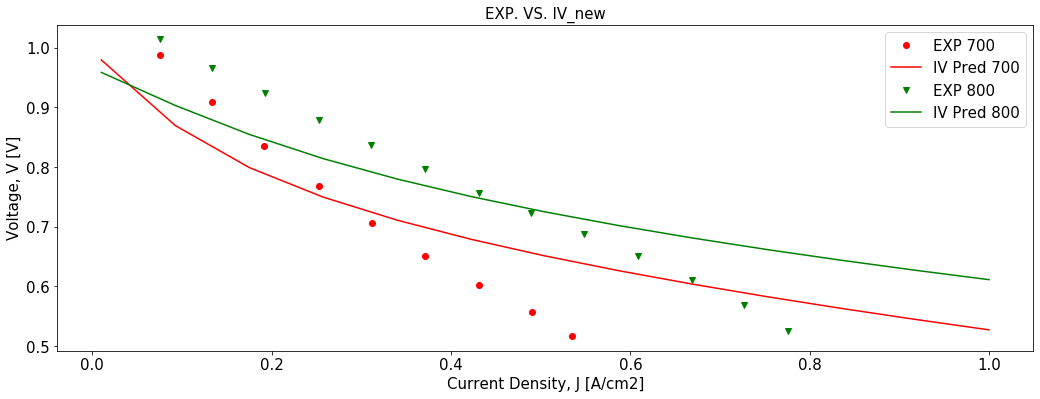

In [41]:
# comparison between JHM-2017 experimental data and IV_new predicitons

Jlist=np.linspace(0.01, 1, num=13)   #Current density, unit [A/cm2]
V_pred = np.zeros(13)
Tlist = [700, 800]
markerlist = ['o', 'v']
colorlist = ['r', 'g']

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './Resources_More/ExperimentalData/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # plot pred data
    for j in range(13):
        V_pred[j], Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                        result.x[0],result.x[1],result.x[2],
                                                        True,de_a,ne_a,alpha_a,de_c,ne_c,alpha_c)
    plt.plot(Jlist, V_pred, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

Text(0.5, 1.0, 'EXP. VS. IV_new')

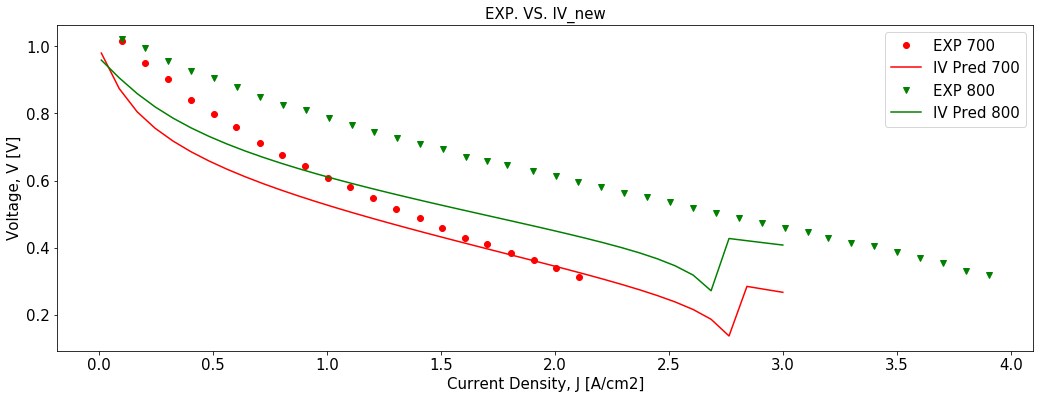

In [42]:
#comparison between Park-2020 experimental data (t8) and IV_new predicitons

Jlist=np.linspace(0.01, 3, num=39)   #Current density, unit [A/cm2]
V_pred = np.zeros(39)
Tlist = [700, 800]
markerlist = ['o', 'v']
colorlist = ['r', 'g']
th_e = 8

plt.figure(figsize=(17.5,6))

for i in range(len(Tlist)):
    oT = Tlist[i]+273.15
    fT = oT
    
    # plot exp data
    filename = './Resources_More/ExperimentalData/t8/'+str(Tlist[i])+'.csv'
    data = np.loadtxt(open(filename, "rb"), delimiter=",", skiprows=1)
    plt.plot(data[:,0], data[:,1], colorlist[i]+markerlist[i], label = 'EXP '+str(Tlist[i]))
    
    # plot pred data
    for j in range(39):
        V_pred[j], Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                        result.x[0],result.x[1],result.x[2],
                                                        True,de_a,ne_a,alpha_a,de_c,ne_c,alpha_c)
    plt.plot(Jlist, V_pred, colorlist[i]+'-', label = 'IV Pred '+str(Tlist[i]))

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
#ymin, ymax = plt.ylim()
#plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel('Current Density, J [A/cm2]', fontsize = 15)
plt.ylabel('Voltage, V [V]', fontsize = 15)
plt.title('EXP. VS. IV_new', fontsize = 15)

In [ ]:
# For reference only: I-V relationship updated in 2017 by updating BV, Ohmic loss, Knudsen diffusion, etc. 
def SV(oT,fT,J,pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,BV_alpha,BV_prexp,BV_Eact,SV1,SV2,SV3,SV4,SV5,SV6,SV7,SV8,SV9,SV10,SV11,SV12,SV13,SV14):
    # -- Initial Values placed here before integration with SOFC-MP
    # local SV_out = {numfields=1}
    # for k,v in pairs(sv_in) do
    #    SV_out.numfields = SV_out.numfields + 1
    #    SV_out[tostring(k)] = v
    # end
    # oT=SV_out["oT"]
    # fT=SV_out["fT"]
    # cT=SV_out["cT"]
    # J=SV_out["J"]
    # --nActiveCell=SV_out["nActiveCell"]
    # --DistanceFromTheEdge=SV_out["DistanceFromTheEdge"]
    # --DistanceFromTheEdgeRatio=SV_out["DistanceFromTheEdgeRatio"]
    # pH2=SV_out["pH2"]
    # pH2O=SV_out["pH2O"]
    # pCO=SV_out["pCO"]
    # pCO2=SV_out["pCO2"]
    # pCH4=SV_out["pCH4"]
    # pN2=SV_out["pN2"]
    # pO2air=SV_out["pO2air"]
    # pN2air=SV_out["pN2air"]
    # SV1=SV_out["SV1"]
    # SV2=SV_out["SV2"]
    # SV3=SV_out["SV3"]
    # SV4=SV_out["SV4"]
    # SV5=SV_out["SV5"]
    # SV6=SV_out["SV6"]
    # SV7=SV_out["SV7"]
    # SV8=SV_out["SV8"]
    # SV9=SV_out["SV9"]
    # SV10=SV_out["SV10"]
    # SV11=SV_out["SV11"]
    # SV12=SV_out["SV12"]
    # SV13=SV_out["SV13"]
    # SV14=SV_out["SV14"]
    #--
    #-- Assign Constants/Conversions
    R=8.3145
    F=96485.0
    atm2Pa=101325.0
    mic2m=1.0e-6
    #--
    #-- reasonble initial values
    # --SV1= 6.1e-7
    # --SV2= 4.75e-7
    # --SV3= 2.00e-6
    # --SV4= 7.00e+8
    # --SV5= 2.05
    # --SV6= 2.5
    # --SV7= 2.5
    # --SV8= 6.1e-7
    # --SV9= 4.75e-7
    # --SV10= 2.00e-6
    # --SV11= SV4
    # --SV12= 2.05
    # --SV13= 2.5
    # --SV14= 2.5
    
    # --Have direct impact
    # --SV3,5,7,10,12,14
    # --Do not have direct impact
    # --SV1,2,4,6,8,9,11,13
    
    #--issue: printflag=1 will cause an issue: no voltage value
    # printflag=0
    # if printflag==1 then
    # checkfile1=io.open("00checkSV1.txt","a")
    # checkfile1:write("In VOC.dat SV1 (d_eaa)= ",SV1,"\n")
    # checkfile1:write("In VOC.dat SV2 (d_iaa)= ",SV2,"\n")
    # --checkfile1:write("In VOC.dat SV3 (d_paa)= ",SV3,"\n")
    # --checkfile1:write("In VOC.dat SV4 (ltpba)= ",SV4,"\n")
    # --checkfile1:write("In VOC.dat SV5 (tortea)= ",SV5,"\n")
    # --checkfile1:write("In VOC.dat SV6 (tortia)= ",SV6,"\n")
    # --checkfile1:write("In VOC.dat SV7 (tortpa)= ",SV7,"\n")
    # --checkfile1:write("In VOC.dat SV8 (d_eac)= ",SV8,"\n")
    # --checkfile1:write("In VOC.dat SV9 (d_iac)= ",SV9,"\n")
    # --checkfile1:write("In VOC.dat SV10(d_pac)= ",SV10,"\n")
    # --checkfile1:write("In VOC.dat SV11(ltpbc)= ",SV11,"\n")
    # --checkfile1:write("In VOC.dat SV12(tortec)= ",SV12,"\n")
    # --checkfile1:write("In VOC.dat SV13(tortic)= ",SV13,"\n")
    # --checkfile1:write("In VOC.dat SV14(tortpc)= ",SV14,"\n")
    # --print(SV1,SV2,SV3,SV4,SV5,SV6,SV7,SV8,SV9,SV10,SV11,SV12,SV13,SV14)
    #   checkfile1:close()
    # end
    # --
    # -- Assign Flags
    BVflag=0     #   -- 0=old method, 1=pressurized method
    # --
    # -- Assign Geometry/Material Data
    th_a=           300.0
    th_e=           10.0
    th_c=           30.0
    th_ic=          500.0
    por_a=          40.0
    por_c=          40.0
    # --tort_a=         2.5
    # --tort_c=         2.5
    tort_a=         SV7
    tort_c=         SV14
    
    # -- Additional microstructural properties added by JHM Dec 2016
    # -- th_aa 	um Anode active layer thickness
    # -- th_ca 	um Cathode active layer thickness
    # -- V_ic 	Vol % ionic conductor in cathode (active layer)
    # -- V_ia 	Vol % ionic conductor in anode (active layer)
    # -- V_eca 	Vol % electr conductor in cathode active layer
    # -- V_eaa	Vol % electr conductor in anode active layer
    # -- V_ec		Vol % of electronic conductor in cathode support
    # -- V_ea		Vol % of electronic conductor in anode support
    # -- tort_ae	Tort of electronic conducting phase in anode
    # -- tort_ce	Tort of electronic conducting phase in cathode
    # -- L_tpb_c	cm/cm**3 Triple phase boundary density in cathode
    # -- L_tpb_a	cm/cm**3 Triple phase boundary density in anode
    
    # -- Additional microstructural properties added by KPR Feb 2017
    # -- d_eaa	um diameter of electr cond particles in act anode
    # -- d_iaa	um diameter of ion cond particles in act anode
    # -- d_eac	um diameter of electr cond particles in act cathode
    # -- d_iac	um diameter of ion cond particles in act cathode
    th_aa =         30.0
    th_ca =         30.0
    if th_ca>th_c:
        th_ca = th_c

    V_ic =          26.0		#--See volfs in EvolutionSV()
    V_ia =          26.0
    V_eca =         100.0-por_c-V_ic
    V_eaa =         100.0-por_a-V_ia
    V_ec =          100.0-por_c
    V_ea =          100.0-por_a
    # --tort_ae =       2.05
    # --tort_ce =       1.21
    # --L_tpb_c =       7.0e8
    # --L_tpb_a =       7.0e8
    L_tpb_cz=       7.0e8
    L_tpb_az=       7.0e8
    tort_ae =       SV5
    tort_ce =       SV12
    L_tpb_c =       SV11		#--Uses SV8, SV9 (via SV1, SV2)
    L_tpb_a =       SV4		#--Uses SV1, SV2
    L_tpb_mean = 2.0/(1.0/L_tpb_c + 1.0/L_tpb_a)
    L_tpbz_mean = 2.0/(1.0/L_tpb_cz + 1.0/L_tpb_az)  #--KPR BV0 fix. Apr5,2017
    #print(L_tpb_a)
    
    # -- Additional microstructural properties added by JHM January 2017
    # -- tort_ai		Tortuosity of ionic conductor in active layer of anode
    # -- tort_ci		Tortuosity of ionic conductor in active layer of cathode
    # -- r_pore_a		cm Average pore radius in anode
    # -- r_pore_c		cm Averyage pore radius in cathode
    # --tort_ai =       2.5
    # --tort_ci =       2.5
    tort_ai =       SV6
    tort_ci =       SV13
    #--r_pore_a =      1.0e-4      
    #--r_pore_c =      1.0e-4
    r_pore_a =      SV3/2.0*100.
    r_pore_c =      SV10/2.0*100.
    
#     BV_alpha=       0.43236/21.5#0.43236
#     BV_prexp=       5639.0
#     BV_Eact=        79616.0*0.98
    R_cont=         0.0
    BV_alpha2a=     2.0
    BV_prexp2a=     465000.0
    BV_Eact2a=      125000.0
    BV_gamma2a=     0.5
    BV_alpha2f=     1.0
    BV_prexp2f=     75000000.0
    BV_Eact2f=      110000.0
    BV_gamma2f=     0.133
    V_loss=         0.0
    
    BV_mod1 =1 #3.8+J*1.3# additional term for matching the overpotential data in 08-31-20_F6_7umYSZ_2YDC1300_LSCF1005_800oC_1_3V.xlsx
   
    #-- Additional microstructural BV terms added by JHM Dec 2016
    #-- scaled to account for Triple Phase Boundary density
    BV_prexp_TPB = BV_prexp/(L_tpbz_mean)  #--KPR BV0 fix. Apr5,2017
    L_tpb_mean_original = 2.0/(1.0/L_tpb_cz + 1.0/L_tpb_az)
    BV_prexp_TPB = BV_prexp/(L_tpb_mean_original) # Jie...
    BV_prexp2a_TPB = BV_prexp2a/L_tpb_cz
    BV_prexp2f_TPB = BV_prexp2f/L_tpb_az
    
    #--
    #-- Compute the local cell temperature
    #------------------------------------------------------------------
    Tk=(oT+fT)/2.0
    Tc=Tk-273.0
    #--
    #-- Compute the Nernst open circuit voltage
    #------------------------------------------------------------------
    Keq_dHo=-56930.0*0.99
    Keq_A=6.75
    Keq_B=-0.64
    Keq_C=-0.08
    Keq_L=-8.74
    Keq_dG=Keq_dHo+Keq_A*Tk*math.log10(Tk)+Keq_B*Tk*Tk/1000+Keq_C*100000/Tk+Keq_L*Tk
    Kequib=math.exp(-Keq_dG*4.184/R/Tk)
    pO2anode=(pH2O/Kequib/pH2)**2
    Voc=(R*Tk/4.0/F)*math.log(pO2air/pO2anode)
    #--
    #-- Compute the ohmic polarization
    #------------------------------------------------------------------
    #-- Compute the electrolyte conductivity
    s_eA=8.588e-10
    s_eB=-1.101e-6
    s_eC=4.679e-4
    s_eD=-0.0654
    s_e=s_eA*Tc**3+s_eB*Tc**2+s_eC*Tc+s_eD
    #-- Compute the interconnect conductivity
    s_icA=0.069
    s_icB=70.9
    s_ic=1000000.0/(s_icA*Tc+s_icB)
    #-- Compute the cathode conductivity
    s_cA=575955.0
    s_cEa=0.117
    
    #-- Old: s_c=(s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*(1.0-(0.018*por_c))
    #----------- New JHM Dec 2016:
    s_c_act = (s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*V_eca/tort_ce*0.01
    s_c = (s_cA/Tk)*math.exp(-s_cEa/0.00008617/Tk)*V_ec/tort_c*0.01
    
    #-- Compute the anode conductivity
    s_aA=1000
    
    #-- Old: s_a=s_aA*(1.0-(0.018*por_a))
    #----------- New JHM Dec 2016:
    s_a_act = s_aA*V_eaa/tort_ae*0.01
    s_a = s_aA*V_ea/tort_a*0.01
    
    #-- Compute the effective cell resistivity
    #-- Updated by JHM January 2017
    Ra = (th_a-th_aa)/s_a + th_aa/s_a_act
    Rc = (th_c-th_ca)/s_c + th_ca/s_c_act
    Re = th_e/s_e
    Rint = th_ic/s_ic
    Ri = R_cont + (Ra + Rc + Re + Rint)*0.0001
    #-- Compute the total ohmic loss
    Ohmic=Ri*J*1.0 #times 0.8 to match 08-31-20_F6_7umYSZ_2YDC1300_LSCF1005_800oC_1_3V  cell2 380h
    #--
    #-- Compute the activation polarization (old method or new pressurized method)
    #------------------------------------------------------------------
    if BVflag==0:
    #  -- Old method
    #    ---------- No TPB:
    #    -- i0=BV_prexp*math.exp(-BV_Eact/R/Tk)
    #    ---------- With TPB JHM Dec 2016:
        i0 = BV_prexp_TPB*L_tpb_mean*math.exp(-BV_Eact/R/Tk)
       
        i0 = BV_prexp_TPB*L_tpb_mean*math.exp(-BV_Eact/R/Tk)
       # print(L_tpb_mean,i0)
        BV=BV_mod1*(R*Tk/BV_alpha/F)*math.log((J*0.1/2.0/i0)+math.sqrt((J*0.1/2.0/i0)**2+1))
        #BV=(R*Tk/BV_alpha/F)*math.log((J/2.0/i0)+math.sqrt((J/2.0/i0)**2+1)) #original
    else:
     #  -- New method
    	# ---------- Without TPB considered
     #  -- ioeff_f=BV_prexp2f*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
     #  -- ioeff_a=BV_prexp2a*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
    	# ---------- With TPB considered JHM Dec 2016
        ioeff_f=BV_prexp2f_TPB*L_tpb_a*math.exp(-BV_Eact2f/R/Tk)*pO2anode**BV_gamma2f
        ioeff_a=BV_prexp2a_TPB*L_tpb_c*math.exp(-BV_Eact2a/R/Tk)*pO2air**BV_gamma2a
    
        eta_f=R*Tk/BV_alpha2f/F*math.log((J/2.0/ioeff_f)+math.sqrt((J/2.0/ioeff_f)**2+1))
        eta_a=R*Tk/BV_alpha2a/F*math.log((J/2.0/ioeff_a)+math.sqrt((J/2.0/ioeff_a)**2+1))
        BV=eta_f+eta_a
    # if printflag==1:
    # --print(BV_prexp2f_TPB, L_tpb_a, BV_Eact2f, pO2anode, BV_gamma2f)
    # --print(R, Tk, BV_alpha2f, J, ioeff_f, F, eta_f, eta_a)
    # --print(BV)
    # end  --end print
    # end
    # --
    # -- Compute the diffusion coefficients
    # ------------------------------------------------------------------
    # -- Make 0.0 species non-zero to make equations defined
    if pCO<=0:
        pCOc=1e-16
    else:
        pCOc=pCO

    if pCO2<=0: 
        pCO2c=1e-16
    else:
        pCO2c=pCO2

    Ptotal=pH2+pH2O+pCOc+pCO2c+pN2+pCH4
    H2_mf=pH2/Ptotal
    H2O_mf=pH2O/Ptotal
    CO_mf=pCOc/Ptotal
    CO2_mf=pCO2c/Ptotal
    N2_mf=pN2/Ptotal
    CH4_mf=pCH4/Ptotal
    #-- Diffusion constants (empirical radii and molecular weights)
    H2i=1.92
    H2Oi=2.33
    COi=2.66
    CO2i=3.0
    N2i=2.62
    O2i=2.55
    CH4i=2.9
    H2ii=2.0
    H2Oii=18.0
    COii=28.0
    CO2ii=44.0
    N2ii=28.0
    O2ii=32.0
    CH4ii=16.0
    #-- Average molecular weight & alphas
    Mavea=H2_mf*H2ii+H2O_mf*H2Oii+CO_mf*COii+CO2_mf*CO2ii+N2_mf*N2ii+CH4_mf*CH4ii
    alH2=1-math.sqrt(H2ii/Mavea)
    alH2O=1-math.sqrt(H2Oii/Mavea)
    alCO=1-math.sqrt(COii/Mavea)
    alCO2=1-math.sqrt(CO2ii/Mavea)
    alN2=1-math.sqrt(N2ii/Mavea)
    alCH4=1-math.sqrt(CH4ii/Mavea)
    #-- get alphas for cathode side
    Ptotc=pO2air+pN2air
    pO2air_mf=pO2air/Ptotc
    pN2air_mf=pN2air/Ptotc
    Mavec=pO2air_mf*O2ii+pN2air_mf*N2ii
    alO2air=1-math.sqrt(O2ii/Mavea)
    alN2air=1-math.sqrt(N2ii/Mavea)
    #-- Compute anode binary diffusion constants
    H2H2O=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/H2Oii)/((H2i+H2Oi)**2)
    H2CO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/COii)/((H2i+COi)**2)
    H2CO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CO2ii)/((H2i+CO2i)**2)
    H2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/N2ii)/((H2i+N2i)**2)
    H2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2ii+1/CH4ii)/((H2i+CH4i)**2)
    O2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/O2ii+1/N2ii)/((O2i+N2i)**2)
    H2OCO=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/COii)/((H2Oi+COi)**2)
    H2OCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CO2ii)/((H2Oi+CO2i)**2)
    H2ON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/N2ii)/((H2Oi+N2i)**2)
    H2OCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/H2Oii+1/CH4ii)/((H2Oi+CH4i)**2)
    N2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/N2ii+1/CH4ii)/((N2i+CH4i)**2)
    COCO2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CO2ii)/((COi+CO2i)**2)
    CON2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/N2ii)/((COi+N2i)**2)
    COCH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/COii+1/CH4ii)/((COi+CH4i)**2)
    CO2N2=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/N2ii)/((CO2i+N2i)**2)
    CO2CH4=(1e-3/Ptotal)*(Tk**1.75)*math.sqrt(1/CO2ii+1/CH4ii)/((CO2i+CH4i)**2)
    
    #-- Compute anode unitary diffusion constants
    H2_UD=(1-H2_mf)/(H2O_mf/H2H2O+CO_mf/H2CO+CO2_mf/H2CO2+N2_mf/H2N2+CH4_mf/H2CH4)
    H2O_UD=(1-H2O_mf)/(H2_mf/H2H2O+CO_mf/H2OCO+CO2_mf/H2OCO2+N2_mf/H2ON2+CH4_mf/H2OCH4)
    CO_UD=(1-CO_mf)/(H2_mf/H2CO+H2O_mf/H2OCO+CO2_mf/COCO2+N2_mf/CON2+CH4_mf/COCH4)
    CO2_UD=(1-CO2_mf)/(H2_mf/H2CO2+H2O_mf/H2OCO2+CO_mf/COCO2+N2_mf/CO2N2+CH4_mf/CO2CH4)
    N2_UD=(1-N2_mf)/(H2_mf/H2N2+H2O_mf/H2ON2+CO_mf/CON2+CO2_mf/CO2N2+CH4_mf/N2CH4)
    CH4_UD=(1-CH4_mf)/(H2_mf/H2CH4+H2O_mf/H2OCH4+CO_mf/COCH4+CO2_mf/CO2CH4+N2_mf/N2CH4)
    
    #-- Compute anode adsorption and surface diffusion modifications
    area_H2=math.pi*(H2i*10**-10)**2
    area_H2O=math.pi*(H2Oi*10**-10)**2
    area_CO=math.pi*(COi*10**-10)**2
    area_CO2=math.pi*(CO2i*10**-10)**2
    area_N2=math.pi*(N2i*10**-10)**2
    area_O2=math.pi*(O2i*10**-10)**2
    area_CH4=math.pi*(CH4i*10**-10)**2
    pres_H2=max(0,pH2-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2_UD*por_a/100)))
    pres_H2O=max(0,pH2O+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(H2O_UD*por_a/100)))
    pres_CO=max(0,pCOc-J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO_UD*por_a/100)))
    pres_CO2=max(0,pCO2c+J*82.058*Tk*(th_a/10000)/(2*F)*(tort_a/(CO2_UD*por_a/100)))
    pres_N2=max(0,pN2)
    pres_O2=max(0,pO2anode)
    pres_CH4=max(0,pCH4)
    Qev_H2=0.425
    Qev_H2O=0.549
    Qev_CO=0.5
    Qev_CO2=0.5
    Qev_N2=0.5
    Qev_O2=0.5
    Qev_CH4=0.5
    bP_H2=6.023*10**23*area_H2*10**-13/math.sqrt(2*math.pi*R*Tk*H2ii)*math.exp(Qev_H2/(0.026*Tk/298))*pres_H2
    bP_H2O=6.023*10**23*area_H2O*10**-13/math.sqrt(2*math.pi*R*Tk*H2Oii)*math.exp(Qev_H2O/(0.026*Tk/298))*pres_H2O
    bP_CO=6.023*10**23*area_CO*10**-13/math.sqrt(2*math.pi*R*Tk*COii)*math.exp(Qev_CO/(0.026*Tk/298))*pres_CO
    bP_CO2=6.023*10**23*area_CO2*10**-13/math.sqrt(2*math.pi*R*Tk*CO2ii)*math.exp(Qev_CO2/(0.026*Tk/298))*pres_CO2
    bP_N2=6.023*10**23*area_N2*10**-13/math.sqrt(2*math.pi*R*Tk*N2ii)*math.exp(Qev_N2/(0.026*Tk/298))*pres_N2
    bP_O2=6.023*10**23*area_O2*10**-13/math.sqrt(2*math.pi*R*Tk*O2ii)*math.exp(Qev_O2/(0.026*Tk/298))*pres_O2
    bP_CH4=6.023*10**23*area_CH4*10**-13/math.sqrt(2*math.pi*R*Tk*CH4ii)*math.exp(Qev_CH4/(0.026*Tk/298))*pres_CH4
    bP_sum=bP_H2+bP_H2O+bP_CO+bP_CO2+bP_N2+bP_O2+bP_CH4
    cov_H2=bP_H2/(1+bP_sum)
    cov_H2O=bP_H2O/(1+bP_sum)
    cov_CO=bP_CO/(1+bP_sum)
    cov_CO2=bP_CO2/(1+bP_sum)
    cov_N2=bP_N2/(1+bP_sum)
    cov_O2=bP_O2/(1+bP_sum)
    cov_CH4=bP_CH4/(1+bP_sum)
    cov_sum=cov_H2+cov_H2O+cov_CO+cov_CO2+cov_N2+cov_O2+cov_CH4
    fij_H2=cov_H2/cov_sum
    fij_H2O=cov_H2O/cov_sum
    fij_CO=cov_CO/cov_sum
    fij_CO2=cov_CO2/cov_sum
    fij_N2=cov_N2/cov_sum
    fij_O2=cov_O2/cov_sum
    fij_CH4=cov_CH4/cov_sum
    DsurfH2th1=0.1
    DsurfH2th2=4.51e-5
    D_H2=H2_UD**fij_H2*((DsurfH2th1**(1-fij_H2)*DsurfH2th2**fij_H2)/(1-fij_H2))**(1-fij_H2)
    D_H2O=H2O_UD**fij_H2O*(10**-4)**(1-fij_H2O)
    D_CO=CO_UD**fij_CO*(10**-4)**(1-fij_CO)
    D_CO2=CO2_UD**fij_CO2*(10**-4)**(1-fij_CO2)
    D_N2=N2_UD**fij_N2*(10**-4)**(1-fij_N2)
    D_O2=O2N2**fij_O2*(10**-4)**(1-fij_O2)
    D_CH4=CH4_UD**fij_CH4*(10**-4)**(1-fij_CH4)
    
    #--checkfile1:write("In VOC.dat D_H2 = ",D_H2,"\n")
    #--
    #-- Compute the cathode concentration polarization
    #------------------------------------------------------------------
    #-- Old Model
    Deffc=0.01*por_c*O2N2/tort_c
    #--checkfile1:write("In VOC.dat DeffcOLD = ",Deffc,"\n")
    #-- New Model - Add Knudsen Diffusion and Pore Radius - JHM January 2016
    convf = 1.0e7
    #    -- Calculate Knudsen Diffusion
    Dk_O2 = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*O2ii))**0.5*r_pore_c
    #--    Deffc = 0.01*por_c/tort_c*(2.0/(1.0/O2N2+1.0/Dk_O2))
    Deffc = 0.01*por_c/tort_c*(1.0/(1.0/O2N2+1.0/Dk_O2))  #--remove factor of 2. KPR. Apr5,2017
    #--io.write("Deffc,1= ",Deffc,"\n")
    Deffc = 0.01*por_c/(tort_c**1)*(1.0/((1.0-alO2air*pO2air_mf)/O2N2+1.0/Dk_O2))
    #--io.write("Deffc,1= ",Deffc,"\n")
    #--checkfile1:write("In VOC.dat Dk_O2 = ",Dk_O2,"\n")
    #--checkfile1:write("In VOC.dat Deffc = ",Deffc,"\n")
    #--
    ics=1.0e-8*(4.0*F*Ptotal*atm2Pa*Deffc)/(R*Tk*th_c*mic2m)*math.log(Ptotal/(Ptotal-pO2air))
    Cath=(R*Tk/4.0/F)*math.log(1.0-(J/ics))
    #--
    # -- Compute the anode concentration polarization
    # ------------------------------------------------------------------
    # -- Old Model
    # --DeffH2_old=D_H2
    # --DeffH2O_old=0.01*H2O_UD*por_a/tort_a
    # --DeffCO_old=0.01*CO_UD*por_a/tort_a
    # --DeffCO2_old=0.01*CO2_UD*por_a/tort_a
    # -- New Model - Add Knudsen Diffusion and Pore Radius - JHM January 2016
    #     -- Calculate Knudsen Diffusion for each species
    Dk_H2 = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*H2ii))**0.5*r_pore_a
    Dk_H2O = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*H2Oii))**0.5*r_pore_a
    Dk_CO = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*COii))**0.5*r_pore_a
    Dk_CO2 = 2.0/3.0*(8.0*R*Tk*convf/(math.pi*CO2ii))**0.5*r_pore_a
    # --    DeffH2 = 2.0/(1.0/D_H2+1.0/(0.01*por_a/tort_a*Dk_H2))
    # --    DeffH2O = 0.01*por_a/tort_a*(2.0/(1.0/H2O_UD+1.0/Dk_H2O))
    # --    DeffCO = 0.01*por_a/tort_a*(2.0/(1.0/CO_UD+1.0/Dk_CO))
    # --    DeffCO2 = 0.01*por_a/tort_a*(2.0/(1.0/CO2_UD+1.0/Dk_CO2))
    # --    DeffH2 = 1.0/(1.0/D_H2+1.0/(0.01*por_a/tort_a*Dk_H2))  --** Removed factor of 2 from Deff
    # --    DeffH2O = 0.01*por_a/tort_a*(1.0/(1.0/H2O_UD+1.0/Dk_H2O))  --** Removed factor of 2 from Deff
    # --    DeffCO = 0.01*por_a/tort_a*(1.0/(1.0/CO_UD+1.0/Dk_CO))  --** Removed factor of 2 from Deff
    # --    DeffCO2 = 0.01*por_a/tort_a*(1.0/(1.0/CO2_UD+1.0/Dk_CO2))  --** Removed factor of 2 from Deff
    # --print(DeffH2, DeffH2O, DeffCO, DeffCO2)
    # --
    DeffH2 = 1.0/(1.0/D_H2+1.0/(0.01*por_a/tort_a**1*Dk_H2))
    DeffH2O = 0.01*por_a/tort_a**1*(1.0/((1.0-alH2O*H2O_mf)/H2O_UD+1.0/Dk_H2O))
    DeffCO = 0.01*por_a/tort_a**1*(1.0/((1.0-alCO*CO_mf)/CO_UD+1.0/Dk_CO))
    DeffCO2 = 0.01*por_a/tort_a**1*(1.0/((1.0-alCO2*CO2_mf)/CO2_UD+1.0/Dk_CO2))
    # --checkfile1:write("In VOC.dat Dk_H2 = ",Dk_H2,"\n")
    # --checkfile1:write("In VOC.dat Dk_H2O = ",Dk_H2O,"\n")
    # --checkfile1:write("In VOC.dat DeffH2 = ",DeffH2,"\n")
    # --checkfile1:write("In VOC.dat DeffH2O = ",DeffH2O,"\n")
    
    alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
    blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
    clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
    dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
    #-- Adjust calculation for iteration case of too high current requested
    if J>(alim+clim+1e10):
        Z=1/0.00001
    else:
        Jcalc=J
        OPa_A=(Jcalc+blim+dlim)/blim/dlim
        OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
        OPa_C=(Jcalc-alim-clim)/alim/clim
        holdA1=OPa_A
        holdB1=OPa_B
        holdC1=OPa_C
        stabcheck=OPa_B**2-4.0*OPa_A*OPa_C
        stabcheck2=(-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A

    #print(stabcheck,stabcheck2)
    
    if stabcheck>0 :
      if stabcheck2>0 :
        Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
        holdA2=0
        holdB2=0
        holdC2=0
        goober=1
      else:
        DeffH2=0.01*H2_UD*por_a/tort_a
        DeffH2O=0.01*H2O_UD*por_a/tort_a
        DeffCO=0.01*CO_UD*por_a/tort_a
        DeffCO2=0.01*CO2_UD*por_a/tort_a
        alim=2*F*pH2*atm2Pa*DeffH2/(831.45*Tk*th_a)
        blim=2*F*pH2O*atm2Pa*DeffH2O/(831.45*Tk*th_a)
        clim=2*F*pCOc*atm2Pa*DeffCO/(831.45*Tk*th_a)
        dlim=2*F*pCO2c*atm2Pa*DeffCO2/(831.45*Tk*th_a)
        OPa_A=(Jcalc+blim+dlim)/blim/dlim
        OPa_B=(Jcalc*(alim*dlim+blim*clim)+blim*clim*dlim+alim*blim*dlim-alim*clim*dlim-alim*blim*clim)/alim/blim/clim/dlim
        OPa_C=(Jcalc-alim-clim)/alim/clim
        holdA2=OPa_A
        holdB2=OPa_B
        holdC2=OPa_C
        Anod=(R*Tk/2.0/F)*math.log((-OPa_B+math.sqrt(OPa_B**2-4.0*OPa_A*OPa_C))/2.0/OPa_A)
        goober=2

    #--Store polarization values for post-processing - KPR, April 14, 2017
    SV15=BV
    SV16=Ohmic
    SV17=Cath+Anod
    #--
    V=(Voc-Ohmic-BV+Cath+Anod)+V_loss
    Z=V
    return (Z,Voc,Ohmic,BV,Cath,Anod)

In [ ]:
# addtional inputs for 2017-version IV relationship/SV
SV1 = de_a #particle size of e-conduct in active anode
SV2 = de_a*alpha_a #particle size of ion-conduct in active anode
SV3 = 2.00e-6 #active anode pore size (diameter, m)  in active anode
SV4 = 7.00e+8 #triple phase boundary length  in active anode
SV5 = 2.05 #SV5,6,7, the anode tortuosities for the 3 phases  in active anode
SV6 = 2.0
SV7 = 2.0
SV8 = 6.1e-7 #particle size of e-conduct in active cathode
SV9 = 4.75e-7 #particle size of ion-conduct in active cathode
SV10 = 2.00e-6
SV11 = 7.00e+8
SV12 = 2.05
SV13 = 2.0
SV14 = 2.0

In [ ]:
V_SV=np.zeros(10)
V_Old=np.zeros(10)
V_New=np.zeros(10)
Jlist=np.linspace(0.2, 2, num=10)             #Current density, unit [A/cm2]

for j in range(10):
    V_SV[j], Voc, Ohmic, BV, Cath, Anode = SV(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                              BV_alpha,BV_prexp,BV_Eact,
                                              SV1,SV2,SV3,SV4,SV5,SV6,SV7,SV8,SV9,SV10,SV11,SV12,SV13,SV14)
    V_Old[j], Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                   BV_alpha,BV_prexp,BV_Eact, 
                                                   False,de_a,ne_a,alpha_a,de_c,ne_c,alpha_c)
    V_New[j], Voc, Ohmic, BV, Cath, Anode = IV_new(oT,fT,Jlist[j],pO2air,pN2air,pH2,pH2O,pCO,pCO2,pCH4,pN2,pSys,
                                                   BV_alpha,BV_prexp,BV_Eact,
                                                   True,de_a,ne_a,alpha_a,de_c,ne_c,alpha_c)
    
X=Jlist
xname = 'Current Density, J [A/cm2]'
yname = 'Voltage, V [V]'

plt.figure(figsize=(17.5,6))
plt.plot(X, V_SV, '-o', label='SV')
plt.plot(X, V_Old, '-d', label='IV Old')
plt.plot(X, V_New, '-s', label='IV New')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)
ymin, ymax = plt.ylim()
plt.ylim(ymin-(ymax-ymin)*0.0, ymax+(ymax-ymin)*0.0)
plt.xlabel(xname, fontsize = 15)
plt.ylabel(yname, fontsize = 15)
plt.title('Comparison between SV, IV, IV_new', fontsize = 15)